# Iris AutoEncoder with Pytorch
On this tutorial we will create a simple AutoEncoder in Pytorch with the Iris Dataset.

#### References
* [Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set)
* [Feature Importance](https://chrisalbon.com/machine_learning/trees_and_forests/feature_importance/)
* [Autoencoders for feature selection](https://arxiv.org/pdf/1710.08310.pdf)
* [Concrete Autoencoders for Differentiable Feature Selection and Reconstruction](https://arxiv.org/pdf/1901.09346.pdf)
* https://github.com/mfbalin/Concrete-Autoencoders
* https://towardsdatascience.com/pca-vs-autoencoders-1ba08362f450

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

# load IRIS dataset
dataset = pd.read_csv('iris.csv')
num_classes = len(dataset.species.unique())
print('Classes:', dataset.species.unique())
num_features = len(dataset.columns) - 1
print('num_features:', num_features)
latent_size = 2
num_hidden = 50

Classes: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
num_features: 4


In [2]:
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


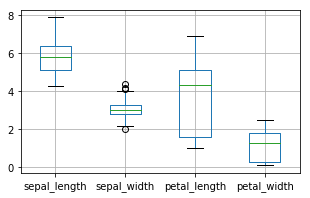

In [3]:
plt.figure(figsize = (5, 3)) 
dataset[["sepal_length", "sepal_width", "petal_length", "petal_width"]].boxplot()

#### Transform Species to a number

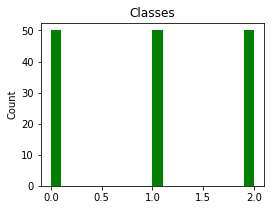

In [4]:
# transform species to numerics
dataset.loc[dataset.species=='Iris-setosa', 'species'] = 0
dataset.loc[dataset.species=='Iris-versicolor', 'species'] = 1
dataset.loc[dataset.species=='Iris-virginica', 'species'] = 2

# Display classes histogram
plt.figure(figsize = (4, 3)) 
x = dataset["species"] 
plt.hist(x, bins = 20, color = "green");
plt.title("Classes");
plt.ylabel("Count"); 

#### Split Train/Test

In [5]:
train_X, test_X, train_y, test_y = train_test_split(dataset[dataset.columns[0:4]].values,
                                                    dataset.species.values, test_size=0.3);

# wrap up with Variable in pytorch
train_X = torch.Tensor(train_X).float()
test_X = torch.Tensor(test_X).float()
train_y = torch.Tensor(train_y).long()
test_y = torch.Tensor(test_y).long()

#### Define a Neural Network

In [6]:
class AutoEncoder(nn.Module):
    # define nn
    def __init__(self, num_features, latent_size, num_hidden=100):
        super(AutoEncoder, self).__init__()
        self.fc1 = nn.Linear(num_features, num_hidden)
        self.fc2 = nn.Linear(num_hidden, latent_size)
        self.fc3 = nn.Linear(latent_size, num_features)        

    def forward(self, X):
        X = F.relu(self.fc1(X))
        latent = self.fc2(X)
        X_reconstruct = self.fc3(latent)        

        return X_reconstruct

#### Initialize Neural Network, Optmizer and Loss

In [7]:
net = AutoEncoder(num_features, latent_size, num_hidden)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

#### Train

In [8]:
for epoch in range(2000):
    optimizer.zero_grad()
    X_reconstruct = net(train_X)    
    loss = criterion(X_reconstruct, train_X)
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print ('number of epoch', epoch, 'loss', loss.item())

with torch.no_grad():
    test_X_rec = net(test_X)

number of epoch 0 loss 25.08379364013672
number of epoch 500 loss 0.02738860622048378
number of epoch 1000 loss 0.02646436169743538
number of epoch 1500 loss 0.026228517293930054


In [9]:
test_X_rec_np = test_X_rec.numpy()
test_X_np = test_X.numpy()

test_orig = pd.DataFrame({'sepal_length': test_X_np[:, 0], 
                          'sepal_width': test_X_np[:, 1], 
                          'petal_length': test_X_np[:, 2], 
                          'petal_width': test_X_np[:, 3]})

test_recons = pd.DataFrame({'sepal_length': test_X_rec_np[:, 0], 
                          'sepal_width': test_X_rec_np[:, 1], 
                          'petal_length': test_X_rec_np[:, 2], 
                          'petal_width': test_X_rec_np[:, 3]})

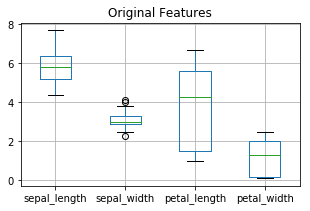

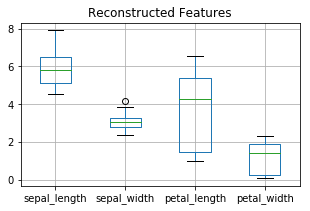

In [10]:
plt.figure(figsize = (5, 3)) 
test_orig[["sepal_length", "sepal_width", "petal_length", "petal_width"]].boxplot()
plt.title('Original Features')
plt.show()

plt.figure(figsize = (5, 3)) 
test_recons[["sepal_length", "sepal_width", "petal_length", "petal_width"]].boxplot()
plt.title('Reconstructed Features')
plt.show()

#### Display Summary of learned features

In [11]:
for name, param in net.named_parameters():
    if param.requires_grad:
        # Print feature name,shape,mean
        print('Name:', name, 'Shape:', param.shape, '\n\tData:',param.data.abs().mean(dim=0))

Name: fc1.weight Shape: torch.Size([50, 4]) 
	Data: tensor([0.2374, 0.2651, 0.2528, 0.2467])
Name: fc1.bias Shape: torch.Size([50]) 
	Data: tensor(0.2646)
Name: fc2.weight Shape: torch.Size([2, 50]) 
	Data: tensor([0.0266, 0.0530, 0.0452, 0.1187, 0.0774, 0.0614, 0.1497, 0.2121, 0.0275,
        0.0612, 0.0736, 0.0995, 0.0955, 0.0145, 0.1016, 0.1216, 0.0914, 0.1293,
        0.0366, 0.0256, 0.0695, 0.0610, 0.0305, 0.0437, 0.1382, 0.0967, 0.4970,
        0.0377, 0.0474, 0.0577, 0.1106, 0.0968, 0.0850, 0.0982, 0.0216, 0.1453,
        0.0756, 0.1032, 0.1538, 0.0633, 0.2501, 0.0690, 0.0546, 0.0861, 0.1862,
        0.0734, 0.1750, 0.1068, 0.1130, 0.0677])
Name: fc2.bias Shape: torch.Size([2]) 
	Data: tensor(0.0316)
Name: fc3.weight Shape: torch.Size([4, 2]) 
	Data: tensor([0.4663, 0.3434])
Name: fc3.bias Shape: torch.Size([4]) 
	Data: tensor(0.2337)
